# Markov Chain Monte-Carlo for a GARCH model

### Libraries set up

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import os
from scipy.optimize import minimize
import csv

### Implementation of a random walk Metropolis sampler that targets the posterior distribution of a GARCH model

I came across a Git repository that explains a simple algorithm for estimating GARCH models using the Metropolis-Hastings algorithm. This resource has inspired me to explore this approach further. The code of this git is in R : https://github.com/tianhanguan/Markov_Chain_Monte_Carlo_methods

### Test with simulated data

##### Simulation of data following a GARCH(1,1) process

In [1]:
N = 5000  #Run size
n = 1000  #Burn-in size
a = [0.3, 0.2, 0.5] # parameters of the GARCH model : omega, alpha, beta 

Generate the GARCH(1,1) process iteratively by its definition. A process $r_{t}$ follows a Garch representation if :

$r_{t} = \epsilon_{t} * \sqrt h_{t}$

$h_{t} = \omega + \alpha*r^{2}_{t-1} + \beta*h_{t-1} $

Where $\epsilon_{t}$ is a weak noise,

And $\omega > 0$, $\alpha > 0$ and $\beta > 0$

GARCH, Generalized Autoregressive Conditional Heteroskedasticity, suppose volatility of time $t$ affects volatility of $t+1$. The volatility is thus not constant.
$h_{t}$ is the variance of $r_{t}$ knowing the volatility and the GARCH value of all the previous period.

In [2]:
def garch_11(parameters, N):   #Size of the generated data
    r = np.zeros(N)  # r corresponds to the Garch process
    h = np.zeros(N)  # h corresponds to the volatility : h=sigma^2

    # We define the initial values of e and h 
    r[0] = 0.1
    h[0] = 0.01

    WN = np.random.normal(0, 1, N)  # noise follows a Normal(0,1)

    for i in range(1, N):
        h[i] = parameters[0] + parameters[1] * r[i-1]**2 + parameters[2] * h[i-1]
        r[i] = np.sqrt(h[i]) * WN[i]

    return r,h

Simulated data of the previously defined GARCH(1,1) process

In [6]:
r_garch = garch_11(a, N)[0][(n + 1):N]

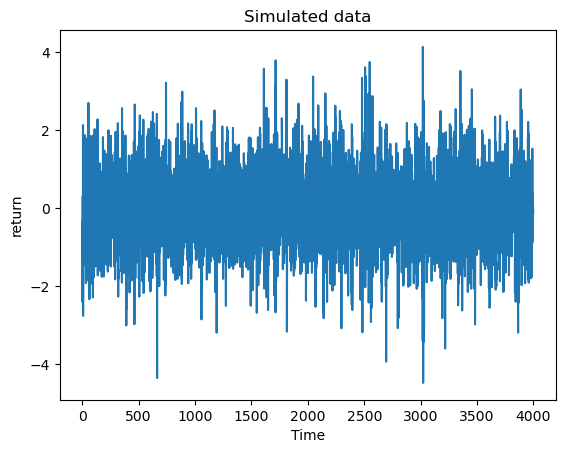

In [7]:
plt.plot(r_garch)
plt.title('Simulated data')
plt.xlabel('Time')
plt.ylabel('return')
plt.show()

In [8]:
h_garch = garch_11(a, N)[1][(n + 1):N]

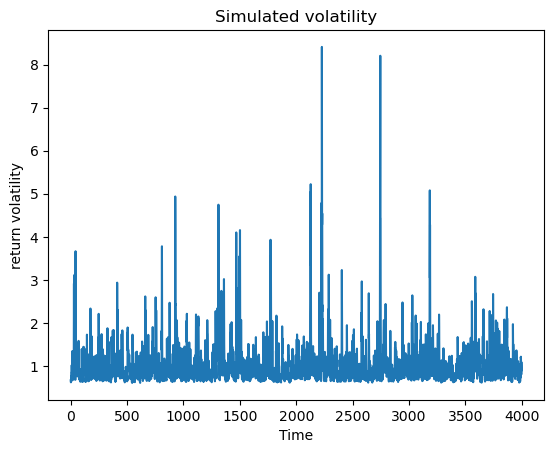

In [9]:
plt.plot(h_garch)
plt.title('Simulated volatility')
plt.xlabel('Time')
plt.ylabel('return volatility')
plt.show()

### Markov Chain Monte-Carlo (MCMC)

We represent the unnormalized density distribution of our target function using a normal distribution that is centered on a single point in the time series. $r_{t}|F_{t−1}$, the garch process, is indeed supposed to follow a normal law distribution $(0,h_{t})$. To compute the log-likelihood of the GARCH process, we iterate through the simulated data at each time step and calculate the probability density of a specific combination of parameters across the entire process.

Function to iteratively calculate the logged posterior distribution :

In [10]:
def g_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial):
    h = h_initial # max g_i initial
    LL = g_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g_i(data[i],h)

    return LL

We chose, with the parameter $n$ above, to burn in a part of the simulated garch processus so we do not know the initial volatility, i.e h[0], of the series. We maximize numerically the density $g_{i}$(r_garch[0],$h$) on $h$ to find the right h_initial for the function g because it is the $h$ that fits the better the initial value of the processus.

In [11]:
def optimize_h(data):
    fun = lambda h: -g_i(data[0], h) # function to minimize
    h_init = 1 # initial value for h
    result = minimize(fun, h_init, method='BFGS') # grandient descent method

    h_optimal = result.x[0] #result
    return h_optimal

optimize_h(r_garch)

0.8161698782237774

We verify this maximization because optimize_h is very sensitive to h_init:

In [12]:
for h in np.arange(round(optimize_h(r_garch))+0.5, round(optimize_h(r_garch)), -0.1):
    print(round(h,2)," :", round(g_i(r_garch[0],h),3))

for h in np.arange(round(optimize_h(r_garch)), round(optimize_h(r_garch))-0.5, -0.1):
    print(round(h,2)," :", round(g_i(r_garch[0],h),3))

1.5  : -0.475
1.4  : -0.46
1.3  : -0.445
1.2  : -0.431
1.1  : -0.419
1.0  : -0.408
0.9  : -0.401
0.8  : -0.399
0.7  : -0.405
0.6  : -0.425


Determination of sigma (volatility for the proposal function): we look for the right order of magnitude of sigma by studying the ratio of densities. If this ratio is either very close to 0 or extremely large which could mean that the difference between X and Y is too large and sigma should be lower. The risk of lowering sigma too much is to have a too high acceptance rate and a too high dependency between the value in the chain. The procedure used is therefore to find the order of magnitude of sigma by seeking to obtain a ratio not to near from 0 or too high (but it depends a lot on X so it is really hard to find a first sigma wich will be adapted according to results), and then validate sigma by running the algorithm and validating a posteriori acceptance rate between 0.2 and 0.6.

PS : We could as well implement an adaptive sigma in the algorythm wich varies according to the acceptance rate

We define the parameters that will be used in the algorithm :

In [13]:
M = 5000 # size of the desired sample
X= [0.2, 0.15, 0.6] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.015  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h=optimize_h(r_garch) #initial h for the density computation

Our objective is to increase the number of draws for combinations of the three parameters where the log-likelihood is high. This will enable us to obtain a more accurate approximation of the sample's expectation. We define two combinations of three parameters: X and a new combination Y, which is a normal deviation from X with volatility sigma. If the probability density of the combination Y is higher than that of X, we accept it as it is likely to better fit our data. However, if the density of Y is lower than that of X, we only accept it if their ratio is higher than a random draw from a uniform distribution between 0 and 1 (U). We also reject Y if any of its three parameters are negative. This process helps us draw more accurate approximations of the sample's expectation.

Warning : we apply log to the density, so it is not a ratio but a difference.

In [14]:
while numaccept < M:

    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = g(Y, data = r_garch, h_initial = h) - g(X, data = r_garch, h_initial = h)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta

        
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)
        print((numaccept/M)*100,"%")

 ... 1000
8.559999999999999 %
 ... 2000
17.740000000000002 %
 ... 3000
26.040000000000003 %
 ... 4000
34.28 %
 ... 5000
42.44 %
 ... 6000
50.1 %
 ... 7000
58.14 %
 ... 8000
65.96 %
 ... 9000
72.8 %
 ... 10000
80.64 %
 ... 11000
87.58 %
 ... 12000
95.94 %


### Exploitation of the results

We plot a visualization of the estimator series to see the evolution of X in the algorythm and the size of the burn in required.

We note on these graph that omega and beta goes often on opposite direction.

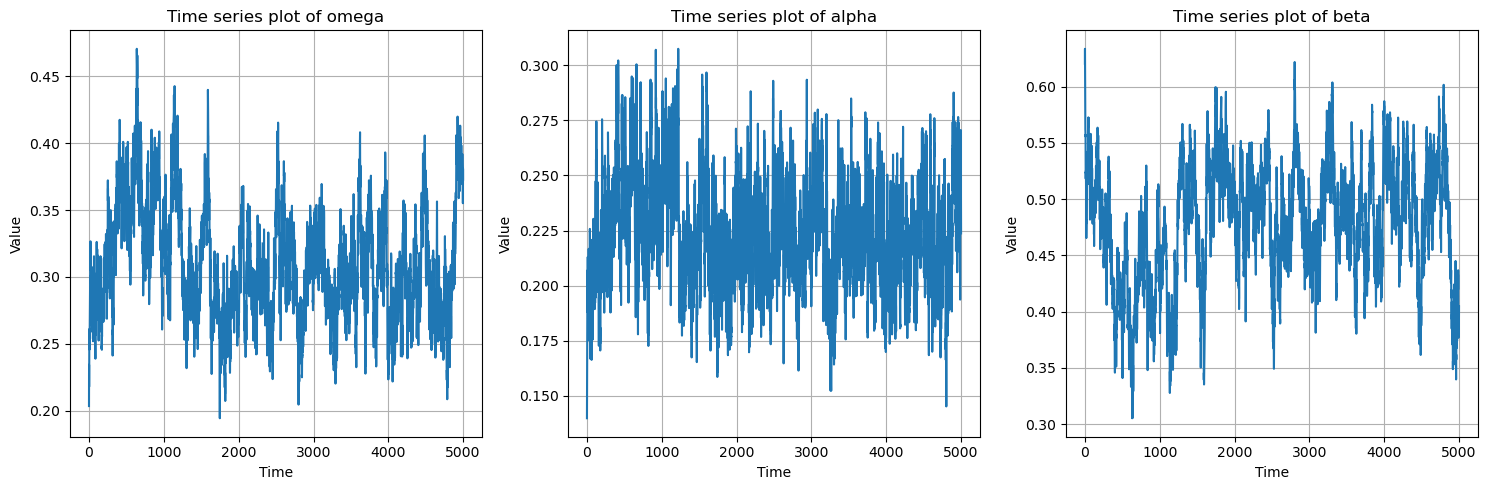

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

We choose a large enough value of burn in to exclude the part of the chain which had probably a low density :

In [16]:
B = 600  # amount of burn-in

We plot the density of the sample for each parameters :

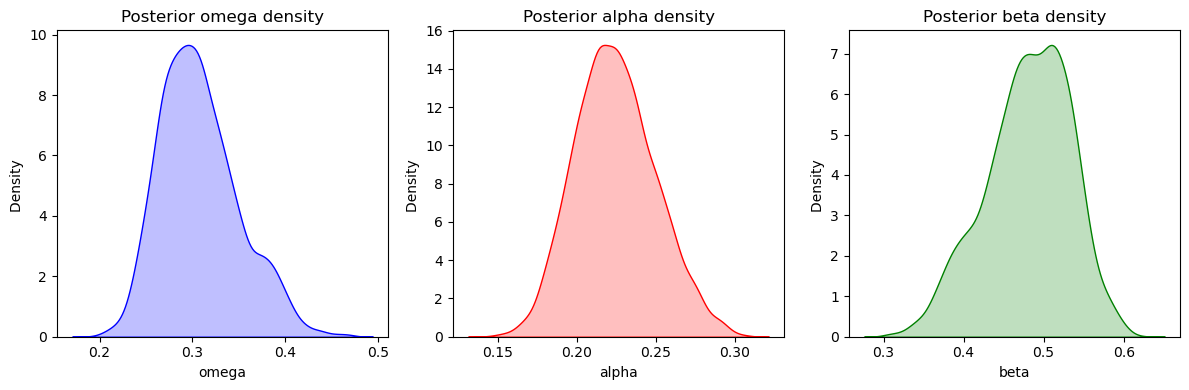

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

We can now determine the parameters by averaging the sample over the values that do not belong to the burn in :

In [18]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 5000 iterations, with burn-in 600
acceptance rate = 0.4004805766920304
mean of x1 is about 0.3074016980943476
mean of x2 is about 0.22419725947419544
mean of x3 is about 0.4800418976252789


Warning : the rejection rate (1-acceptance rate) takes into account the rejections due to negative parameters. In this example, Y rarely takes negative values because the true parameters are far enough from 0. However, with true data, we can have parameters close to 0 and therefore often have Y rejected because at least one of its parameters is negative. We will therefore present an alternative way to code the algorithm.

We calculate the standard error and the true standard error to determine the confidence intervals of our estimators:

In [19]:
def varfact(x): # function to get a variance factor used to obtain true standard error (because of the serial correlation)
    acf_vals = acf(x, nlags=None, fft=True)  # acf comutation
    var_factor = 2 * np.sum(acf_vals) - 1  # variance factor computation
    return var_factor

In [20]:
# Computation the standard deviations of the x1list, x2list and x3list
se11 = np.std(x1list[(B):(len(x1list))]) / np.sqrt(len(x1list)-B)
se12 = np.std(x2list[(B):(len(x2list))]) / np.sqrt(len(x2list)-B)
se13 = np.std(x3list[(B):(len(x3list))]) / np.sqrt(len(x3list)-B)

# Compute the variance factor of the x1list, x2list and x3list
thevarfact1 = varfact(x1list[(B):(len(x1list))])
thevarfact2 = varfact(x2list[(B):(len(x2list))])
thevarfact3 = varfact(x3list[(B):(len(x3list))])

# Compute the true standard errors of the x1list, x2list and x3list
se1 = se11 * np.sqrt(thevarfact1)
se2 = se12 * np.sqrt(thevarfact2)
se3 = se13 * np.sqrt(thevarfact3)

# Display and compute the 95% confidencce interval
print("true standard error of omega is about", se1)
print("approximate 95% confidence interval of omega is (", u - 1.96 * se1, ",", u + 1.96 * se1, ")\n")

print("true standard error of alpha is about", se2)
print("approximate 95% confidence interval of alpha is (", v - 1.96 * se2, ",", v + 1.96 * se2, ")\n")

print("true standard error of beta is about", se3)
print("approximate 95% confidence interval of beta is (", w - 1.96 * se3, ",", w + 1.96 * se3, ")\n")

true standard error of omega is about 0.004435028405482298
approximate 95% confidence interval of omega is ( 0.2987090424196023 , 0.3160943537690929 )

true standard error of alpha is about 0.001850424769022757
approximate 95% confidence interval of alpha is ( 0.22057042692691084 , 0.22782409202148005 )

true standard error of beta is about 0.005623362602594062
approximate 95% confidence interval of beta is ( 0.4690201069241945 , 0.49106368832636327 )



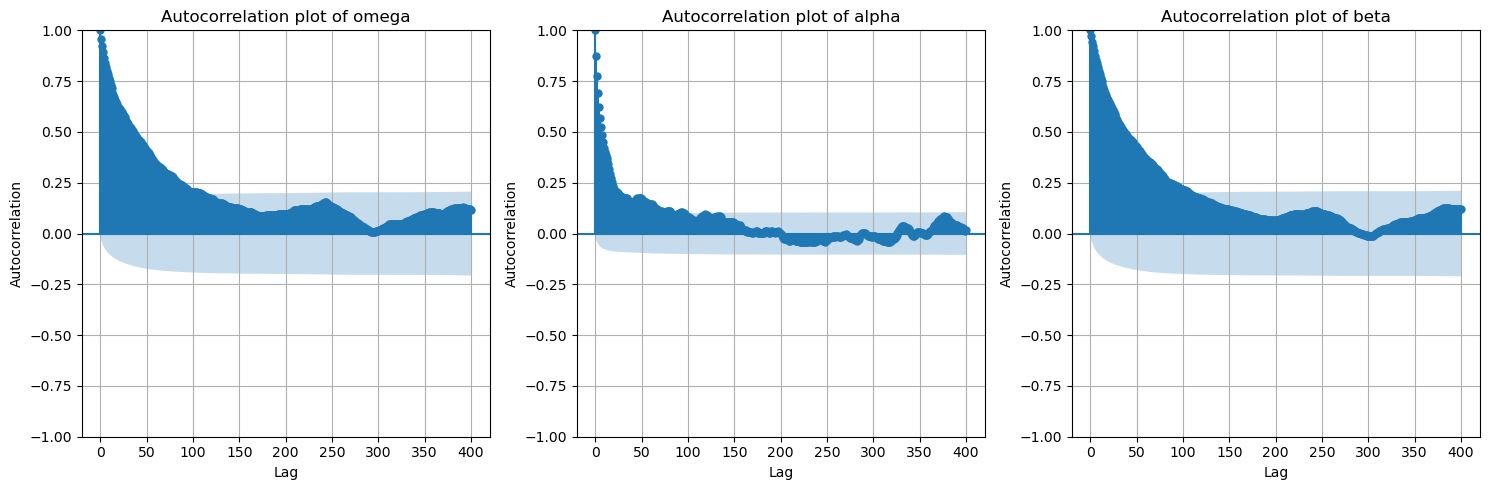

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Autocorrelation function plot for each markov chain 
plot_acf(x1list, ax=axs[0], lags=400)
axs[0].set_title("Autocorrelation plot of omega")
plot_acf(x2list, ax=axs[1], lags=400)
axs[1].set_title("Autocorrelation plot of alpha")
plot_acf(x3list, ax=axs[2], lags=400)
axs[2].set_title("Autocorrelation plot of beta")

# title and labels setting
for ax in axs:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)

# display
plt.tight_layout()
plt.show()

Following graphs display the correlation between value in the series to ensure that there is no to much dependance between values or to choose a value for subsampling.

We store the 3 samples constructed with the simple algorithm to later compare the variance of these samples with the variance of the samples from the algorithm with control variate.

In [26]:
mcmc_results = pd.DataFrame({'omega': x1list, 'alpha': x2list, 'beta': x3list})
mcmc_results.to_csv('mcmc_results.csv', index=False)

### Test with real data

#### Return on exchange rate

We import real data, euro/dollar exchange rates in order to test the MCMC in a rigorous way:

In [32]:
data = pd.read_csv("euro-daily-hist_1999_2022.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6229 entries, 0 to 6228
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Period\Unit:              6229 non-null   object 
 1   [Australian dollar ]      6229 non-null   object 
 2   [Bulgarian lev ]          5827 non-null   object 
 3   [Brazilian real ]         5961 non-null   object 
 4   [Canadian dollar ]        6229 non-null   object 
 5   [Swiss franc ]            6229 non-null   object 
 6   [Chinese yuan renminbi ]  5961 non-null   object 
 7   [Cypriot pound ]          2346 non-null   object 
 8   [Czech koruna ]           6229 non-null   object 
 9   [Danish krone ]           6229 non-null   object 
 10  [Estonian kroon ]         3130 non-null   object 
 11  [UK pound sterling ]      6229 non-null   object 
 12  [Greek drachma ]          520 non-null    object 
 13  [Hong Kong dollar ]       6229 non-null   object 
 14  [Croatia

In [36]:
data.head()

,Period\Unit:,[Australian dollar ],[Bulgarian lev ],[Brazilian real ],[Canadian dollar ],[Swiss franc ],[Chinese yuan renminbi ],[Cypriot pound ],[Czech koruna ],[Danish krone ],...,[Romanian leu ],[Russian rouble ],[Swedish krona ],[Singapore dollar ],[Slovenian tolar ],[Slovak koruna ],[Thai baht ],[Turkish lira ],[US dollar ],[South African rand ]
0,2023-01-27,1.5289,1.9558,5.5104,1.4479,1.0017,7.3690,NaN,23.826,7.4378,...,4.8965,NaN,11.2108,1.4277,NaN,NaN,35.7020,20.4365,1.0865,18.7185
1,2023-01-26,1.5308,1.9558,5.5572,1.4568,1.0002,7.3893,NaN,23.818,7.4383,...,4.8818,NaN,11.1763,1.4292,NaN,NaN,35.6870,20.4961,1.0895,18.6127
2,2023-01-25,1.5360,1.9558,5.5690,1.4544,1.0020,7.3778,NaN,23.808,7.4381,...,4.9035,NaN,11.1335,1.4307,NaN,NaN,35.7180,20.4658,1.0878,18.6745
3,2023-01-24,1.5470,1.9558,5.6164,1.4517,1.0053,7.3642,NaN,23.874,7.4399,...,4.9171,NaN,11.0995,1.4337,NaN,NaN,35.6090,20.4234,1.0858,18.7687
4,2023-01-23,1.5529,1.9558,5.6372,1.4523,1.0013,7.3730,NaN,23.881,7.4393,...,4.9202,NaN,11.1183,1.4328,NaN,NaN,35.6300,20.4478,1.0871,18.6597


Log transformation to get the return of the exchange rate:

In [37]:
exchange_rate = pd.to_numeric(data['[UK pound sterling ]'], errors='coerce').astype(float)
s_t = exchange_rate[1:].reset_index(drop = True)
s_t_1 = exchange_rate[:-1].reset_index(drop = True)
rendement = np.log(s_t/s_t_1) #variation of exchange rate corresponds to the return
rendement = np.array(rendement)
rendement = rendement[2000:6000] # take just a portion of it because large CPU time 
rendement=rendement*100 #take it in percentage to not have parameters to close from 0

We can see on the following plot that the volatily is not constant and depend from previous period so a Garch model is adapted.

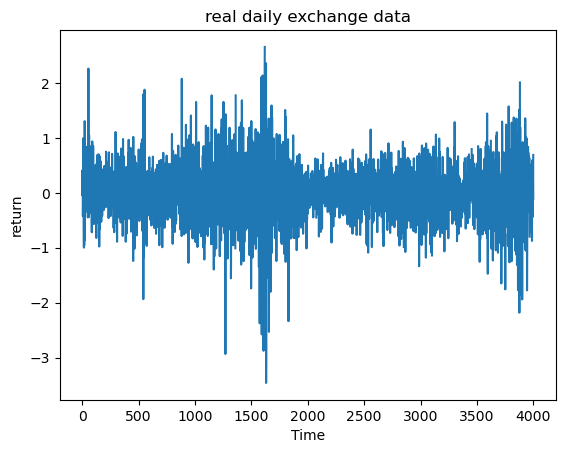

In [39]:
plt.plot(rendement)
plt.title('real daily exchange data')
plt.xlabel('Time')
plt.ylabel('return')
plt.show()

There are missing values :

In [40]:
np.sum(np.isnan(rendement))

103

We basically delete them :

In [42]:
rendement = rendement[~np.isnan(rendement)]

### MCMC

We seek for the right initial h firstly thanks to the max of g_i for the first value of the series:

In [45]:
for h in np.arange(0.1, 0.3, 0.01):
    print(round(h,2)," :", round(g_i(rendement[0],h),3))

0.1  : 0.347
0.11  : 0.372
0.12  : 0.39
0.13  : 0.401
0.14  : 0.408
0.15  : 0.412
0.16  : 0.413
0.17  : 0.413
0.18  : 0.41
0.19  : 0.407
0.2  : 0.402
0.21  : 0.397
0.22  : 0.391
0.23  : 0.385
0.24  : 0.378
0.25  : 0.371
0.26  : 0.364
0.27  : 0.357
0.28  : 0.349
0.29  : 0.342


In [99]:
M = 3000 # size of the desired sample
X = [0.002, 0.055, 0.92] #appropriate initial X for the markov chain
sigma = 0.001  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i
h=0.16 #initial series volatility

In [100]:
while numaccept < M:
    
    Y = X + np.random.normal(loc=0, scale=sigma, size=3) # Proposal move with a normal distribution (dim=3 because 3 parameters)
    while np.any(Y <= 0): # Reject all samples where any parameter is negative (but so that it is not counted in the acceptance rate)
        Y = X + np.random.normal(loc=0, scale=sigma, size=3)  
    
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    alpha = g(Y, data = rendement, h_initial = h) - g(X, data = rendement, h_initial = h)  # Difference between current and previous density accept/reject
    
    if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
        X = Y # Accept proposal
        numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm

        x1list.append(X[0])   # Add the values to the lists of omega
        x2list.append(X[1])   # Add the values to the lists of alpha
        x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0: 
        print("...", i)
        print((numaccept/M)*100, "%")

... 1000
7.9 %
... 2000
15.333333333333332 %
... 3000
22.966666666666665 %
... 4000
30.7 %
... 5000
38.56666666666666 %
... 6000
45.7 %
... 7000
53.6 %
... 8000
62.76666666666667 %
... 9000
70.33333333333334 %
... 10000
78.53333333333333 %
... 11000
87.33333333333333 %
... 12000
94.0 %


#### Exploitation of the results 

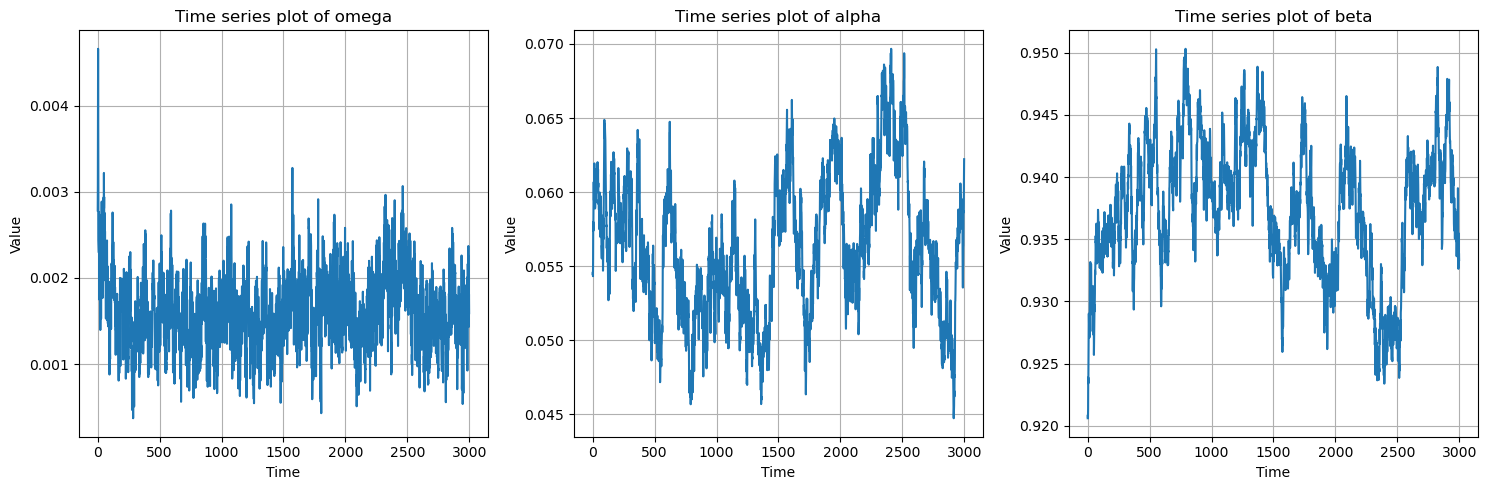

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [110]:
B = 400 # amount of burn-in

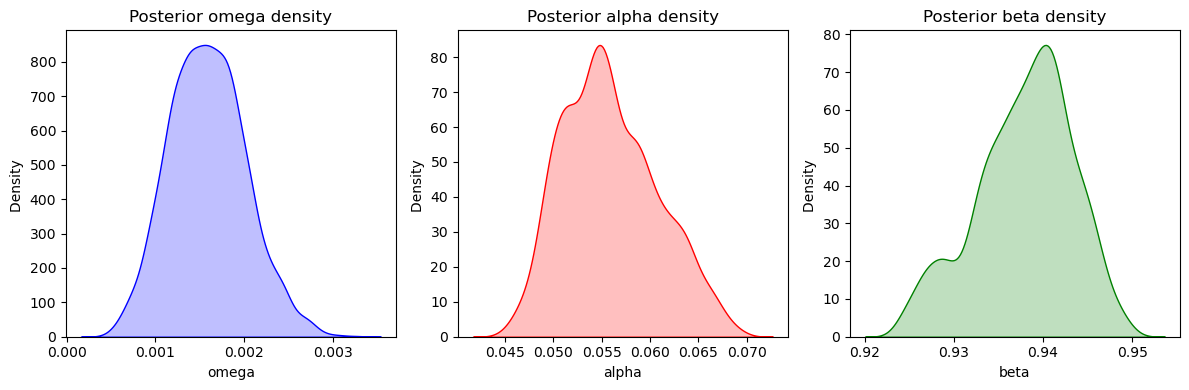

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between graph
plt.tight_layout()

# display
plt.show()

In [112]:
print("Ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("Acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

Ran Metropolis algorithm for 3000 iterations, with burn-in 400
Acceptance rate = 0.2334267040149393
mean of x1 is about 0.0015882898538634516
mean of x2 is about 0.05586492544745616
mean of x3 is about 0.9378744113405817


In [113]:
# Computation the standard deviations of the x1list, x2list and x3list
se11 = np.std(x1list[(B):(len(x1list))]) / np.sqrt(len(x1list)-B)
se12 = np.std(x2list[(B):(len(x2list))]) / np.sqrt(len(x2list)-B)
se13 = np.std(x3list[(B):(len(x3list))]) / np.sqrt(len(x3list)-B)

# Compute the variance factor of the x1list, x2list and x3list
thevarfact1 = varfact(x1list[(B):(len(x1list))])
thevarfact2 = varfact(x2list[(B):(len(x2list))])
thevarfact3 = varfact(x3list[(B):(len(x3list))])

# Compute the true standard errors of the x1list, x2list and x3list
se1 = se11 * np.sqrt(thevarfact1)
se2 = se12 * np.sqrt(thevarfact2)
se3 = se13 * np.sqrt(thevarfact3)

# Display and compute the 95% confidencce interval
print("true standard error of omega is about", se1)
print("approximate 95% confidence interval of omega is (", u - 1.96 * se1, ",", u + 1.96 * se1, ")\n")

print("true standard error of alpha is about", se2)
print("approximate 95% confidence interval of alpha is (", v - 1.96 * se2, ",", v + 1.96 * se2, ")\n")

print("true standard error of beta is about", se3)
print("approximate 95% confidence interval of beta is (", w - 1.96 * se3, ",", w + 1.96 * se3, ")\n")

true standard error of omega is about 3.4682571321122265e-05
approximate 95% confidence interval of omega is ( 0.001520312014074052 , 0.0016562676936528512 )

true standard error of alpha is about 0.000720106956086921
approximate 95% confidence interval of alpha is ( 0.054453515813525796 , 0.05727633508138652 )

true standard error of beta is about 0.0007898874320840727
approximate 95% confidence interval of beta is ( 0.9363262319736969 , 0.9394225907074665 )



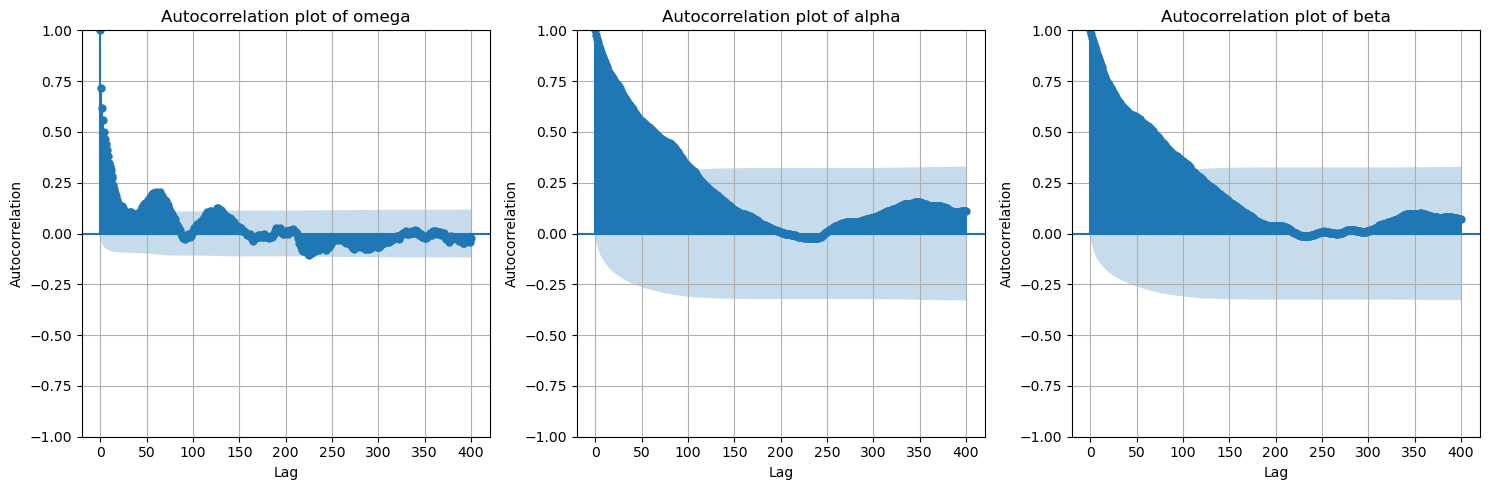

In [115]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Autocorrelation function plot for each markov chain 
plot_acf(x1list, ax=axs[0], lags=400)
axs[0].set_title("Autocorrelation plot of omega")
plot_acf(x2list, ax=axs[1], lags=400)
axs[1].set_title("Autocorrelation plot of alpha")
plot_acf(x3list, ax=axs[2], lags=400)
axs[2].set_title("Autocorrelation plot of beta")

# title and labels setting
for ax in axs:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)

# display
plt.tight_layout()
plt.show()

Upon analyzing the data, we observed that each sample appears to be uncorrelated when using a lag of 225. As a result, we may consider subsampling our data using this lag interval.